In [42]:
import mido
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
import sys

import librosa
import mido 

sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *

## Load MIDI data

In [14]:
def midi_to_seq(file):
    """  
    Takes a midi file and extracts the sequence of midi values
    If there are multiple tracks (although there shouldn't be), extracts midi values from all tracks
    returns: note_arr, sequence of notes
    """
    midi_file = mido.MidiFile(file)
    note_arr = []
    for i, track in enumerate(midi_file.tracks):
        print(f"Processing track {i}: {track.name}")
        assert i == 0, 'multiple tracks detected'
            
        note_seq = []
        for msg in track:

            if msg.type == 'note_on':
                note_seq.append(msg.note)
        note_arr.append(note_seq)
        note_arr = np.array(note_arr).squeeze()
    
    return note_arr

In [65]:
def midi_to_onsets(file, fs):

    """ 
    takes a midi files and returns the onset times
    todo: in seconds since the beginning of the file?
    """
    midi_file = mido.MidiFile(file)
    onsets = []
    absolute_time = 0
    for i, track in enumerate(midi_file.tracks):
        print(f"Processing track {i}: {track.name}")
        assert i == 0, 'multiple tracks detected'
        for msg in track:
                absolute_time += msg.time
                if msg.type == 'note_on':
                    onsets.append(absolute_time)
        
    return onsets

onsets = midi_to_onsets('t2-keystrokes 12_3.mid')


96
Processing track 0: t2-keystrokes 12


In [162]:


def midi_to_onsets2(file, fs, tempo = 1000000, precrop = 10, postcrop = 10):
    """
    Takes a MIDI file and returns the onset times in seconds since the beginning of the file.

    Parameters:
    file (str): Path to the MIDI file.
    fs (int): Sampling rate, e.g., 128 Hz (optional for syncing with another array).
    tempo: defaults to 1 000 000 or 60 BPM
    precrop, postcrop: how much to crop the midi file at beginning and end

    Returns:
    list: Onset times in seconds since the beginning of the file.
    """
    midi_file = mido.MidiFile(file)
    onsets = []
    absolute_time = 0

    # Default tempo in microseconds per quarter note (if no set_tempo message is found)
    #tempo = 250000  # 120 BPM

    # Ticks per beat (PPQN)
    ticks_per_beat = midi_file.ticks_per_beat

    

    for i, track in enumerate(midi_file.tracks):
        print(f"Processing track {i}: {track.name}")
        assert i == 0, 'Multiple tracks detected; only the first track will be processed.'

        for msg in track:
            # Increment the absolute time by the delta time
            absolute_time += msg.time

            

            # Convert delta time to seconds and store onset times for 'note_on' messages
            if msg.type == 'note_on' and msg.velocity > 0:  # Ignore velocity=0 (note_off)
                time_in_seconds = absolute_time * (tempo / (ticks_per_beat * 1_000_000))
                onsets.append(time_in_seconds)

        onsets = np.array(onsets)
       # onsets = onsets[(onsets > 10) & (onsets < 610)] #crop out parts not in eeg
       # onsets = (onsets - 10)*128

    return onsets

onsets_orig = midi_to_onsets2('t2-keystrokes 12_new.mid', fs = 128)


Processing track 0: t2-keystrokes 12


In [163]:
onsets_orig

array([  5.85416667,   6.90625   ,   7.92708333,   8.98958333,
        13.42708333,  14.5       ,  15.65625   ,  16.70833333,
        19.82291667,  21.        ,  22.26041667,  23.47916667,
        27.29166667,  28.42708333,  29.54166667,  30.84375   ,
        34.3125    ,  35.41666667,  36.48958333,  38.17708333,
        41.76041667,  42.82291667,  43.96875   ,  44.94791667,
        49.42708333,  53.66666667,  55.        ,  56.23958333,
        58.83333333,  59.65625   ,  60.66666667,  61.78125   ,
        66.05208333,  67.08333333,  68.        ,  69.09375   ,
        71.72916667,  71.85416667,  72.67708333,  73.875     ,
        74.88541667,  81.15625   ,  82.19791667,  83.08333333,
        84.19791667,  87.92708333,  89.0625    ,  90.01041667,
        91.        ,  93.89583333,  94.98958333,  96.11458333,
        97.17708333,  99.70833333, 100.59375   , 101.45833333,
       102.39583333, 106.84375   , 109.48958333, 113.57291667,
       114.5625    , 116.10416667, 122.0625    , 123.04

In [164]:
onsets_orig.shape

(334,)

In [156]:


# Load the audio file
y, sr = librosa.load("audio_clicktrack.wav", sr=None)

# Detect onsets
onset_frames = librosa.onset.onset_detect(y=y, sr=sr, units='time')
print(f"Onset timings: {onset_frames}")


Onset timings: [  5.87464853   6.91954649   7.94122449   9.0093424   13.44435374
  14.51247166  15.67346939  16.71836735  19.84145125  21.01405896
  22.26793651  23.48698413  27.30666667  28.44444444  29.55900227
  30.85931973  34.33070295  35.42204082  36.50176871  38.18521542
  41.77269841  42.84081633  43.99020408  44.9538322   49.44689342
  53.68453515  55.01968254  56.25034014  58.83936508  59.67528345
  60.68535147  61.7999093   66.07238095  67.09405896  68.01124717
  69.10258503  71.74965986  71.86575964  72.69006803  73.88589569
  74.89596372  81.16535147  82.22185941  83.10421769  84.20716553
  87.94557823  89.08335601  90.02376417  91.01061224  93.91310658
  95.00444444  96.13061224  97.18712018  99.71809524 100.61206349
 101.48281179 102.41160998 106.85823129 109.50530612 113.59201814
 114.57886621 116.1229932  122.07891156 123.06575964 124.07582766
 127.37306122 128.31346939 129.20743764 130.13623583 133.29414966
 134.40870748 135.33750567 136.30113379 139.51709751 140.4342

In [160]:
note_seq

array([53, 55, 57, 59, 60, 59, 55, 53, 53, 57, 55, 59, 60, 59, 57, 55, 53,
       57, 55, 59, 60, 59, 57, 55, 53, 57, 55, 57, 60, 59, 57, 55, 53, 57,
       55, 59, 60, 59, 59, 57, 55, 53, 57, 55, 59, 60, 59, 57, 55, 53, 57,
       55, 59, 55, 57, 59, 60, 57, 59, 60, 57, 55, 55, 57, 59, 53, 55, 57,
       59, 60, 59, 57, 55, 53, 57, 55, 59, 60, 59, 57, 55, 53, 57, 55, 59,
       60, 59, 57, 55, 59, 57, 55, 53, 53, 53, 55, 57, 60, 59, 60, 57, 53,
       57, 55, 59, 60, 59, 57, 55, 53, 57, 55, 59, 60, 59, 57, 55, 53, 55,
       57, 57, 59, 57, 59, 55, 53, 55, 57, 53, 60, 59, 57, 60, 59, 53, 57,
       55, 60, 59, 57, 55, 53, 57, 55, 59, 60, 57, 59, 55, 53, 55, 57, 53,
       60, 59, 57, 55, 60, 57, 60, 59, 60, 59, 57, 55, 53, 55, 57, 53, 59,
       57, 55, 53, 53, 55, 57, 60, 60, 57, 59, 55, 53, 59, 57, 59, 55, 57,
       53, 59, 60, 53, 57, 53, 55, 57, 59, 55, 57, 59, 60, 57, 53, 55, 57,
       53, 57, 59, 60, 57, 60, 57, 53, 59, 55, 53, 59, 55, 57, 53, 59, 55,
       57, 53, 60, 59, 57

In [158]:
note_seq = midi_to_seq('t2-keystrokes 12_v2.mid') #motor post for sub 12

Track 0: t2-keystrokes 12


In [170]:
onsets_orig_fs = (onsets_orig-10)*128

In [169]:
t_keystrokes

array([[  438,     0,     2],
       [  576,     0,     2],
       [  724,     0,     2],
       [  858,     0,     2],
       [ 1258,     0,     2],
       [ 1407,     0,     2],
       [ 1568,     0,     2],
       [ 1724,     0,     2],
       [ 2212,     0,     2],
       [ 2358,     0,     2],
       [ 2501,     0,     2],
       [ 2668,     0,     2],
       [ 3111,     0,     2],
       [ 3252,     0,     2],
       [ 3390,     0,     2],
       [ 3605,     0,     2],
       [ 4065,     0,     2],
       [ 4200,     0,     2],
       [ 4348,     0,     2],
       [ 4472,     0,     2],
       [ 5046,     0,     2],
       [ 5590,     0,     2],
       [ 5760,     0,     2],
       [ 5919,     0,     2],
       [ 6250,     0,     2],
       [ 6355,     0,     2],
       [ 6485,     0,     2],
       [ 6628,     0,     2],
       [ 7174,     0,     2],
       [ 7305,     0,     2],
       [ 7423,     0,     2],
       [ 7563,     0,     2],
       [ 7901,     0,     2],
       [ 8

In [171]:
onsets_orig_fs

array([ -530.66666667,  -396.        ,  -265.33333333,  -129.33333333,
         438.66666667,   576.        ,   724.        ,   858.66666667,
        1257.33333333,  1408.        ,  1569.33333333,  1725.33333333,
        2213.33333333,  2358.66666667,  2501.33333333,  2668.        ,
        3112.        ,  3253.33333333,  3390.66666667,  3606.66666667,
        4065.33333333,  4201.33333333,  4348.        ,  4473.33333333,
        5046.66666667,  5589.33333333,  5760.        ,  5918.66666667,
        6250.66666667,  6356.        ,  6485.33333333,  6628.        ,
        7174.66666667,  7306.66666667,  7424.        ,  7564.        ,
        7901.33333333,  7917.33333333,  8022.66666667,  8176.        ,
        8305.33333333,  9108.        ,  9241.33333333,  9354.66666667,
        9497.33333333,  9974.66666667, 10120.        , 10241.33333333,
       10368.        , 10738.66666667, 10878.66666667, 11022.66666667,
       11158.66666667, 11482.66666667, 11596.        , 11706.66666667,
      

## EEG import

In [59]:
data = loadmat('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed_30Hz/12/eeg_motor_post_12.mat')

In [60]:
events_sv = data['events']
events_arr = make_raw_events(events_sv)
t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])

In [61]:
t_keystrokes.shape

(258, 3)

(0.0, 2000.0)

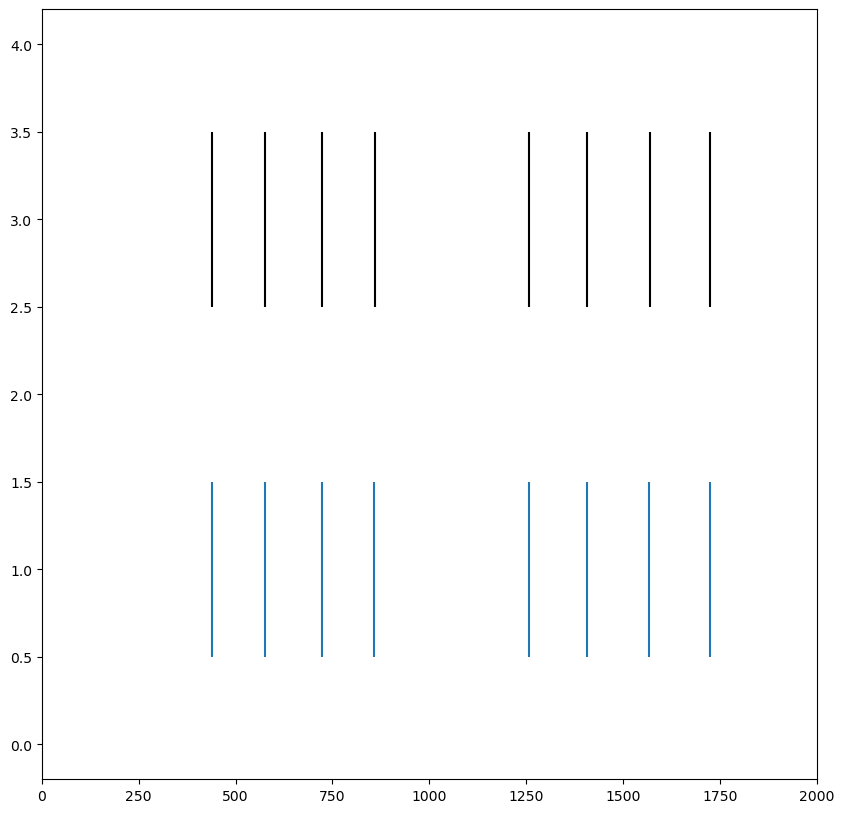

In [174]:
plt.figure(figsize = (10,10))
plt.eventplot(t_keystrokes[:,0])
plt.eventplot(onsets_orig_fs, lineoffsets=3, color = 'black')


In [177]:
import matplotlib
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [179]:
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'